In [32]:
import sys
sys.path.append('../semana1/')
from aux_functions import read_data
from CNN_Net import Net
from pathlib import Path
from joblib import load

import torch
from pytorch_metric_learning import distances, losses, reducers, testers
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

In [6]:
DATA_DIR = Path('../data/d1+d2-patches/')
EMBEDDING_SIZE = 128
TRAIN_SIZE = .7
BATCH_SIZE = 128
IMG_SIZE = (1, 96, 96)
LEARNING_RATE = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Loading files
Dataset 1 + 2 (21734 leishs and 43468 no-leishs) \
Previously, triplet, multisimilarity and cosface were recognized as the best fit

In [7]:
x_train, x_test, x_train_loader, x_test_loader, y_true_train, y_true_test = read_data(DATA_DIR, BATCH_SIZE, TRAIN_SIZE)

label format = {'leish': 0, 'no-leish': 1}
train test split proportion = train[45641], test[19561]
leish in training set = 15163
leish in testing set = 6571


In [13]:
######################################## TRIPLET

triplet_model = Net(EMBEDDING_SIZE, IMG_SIZE).to(device)
triplet_model.load_state_dict(torch.load('./models/v1-ensble_2023-11-23\model_D1_Triplet_v1-ensble_2023-11-23.pth'))

triplet_model.eval()

triplet_clf = load('./models/v1-ensble_2023-11-23\clf_D1_Triplet_v1-ensble_2023-11-23.joblib')
triplet_scaler = load('./models/v1-ensble_2023-11-23\scaler_D1_Triplet_v1-ensble_2023-11-23.joblib')
triplet_pca = load('./models/v1-ensble_2023-11-23\pca_D1_Triplet_v1-ensble_2023-11-23.joblib')
######################################## COSFACE

cosface_model = Net(EMBEDDING_SIZE, IMG_SIZE).to(device)
cosface_model.load_state_dict(torch.load('./models/v1-ensble_2023-11-23\model_D1_CosFace_v1-ensble_2023-11-23.pth'))

cosface_model.eval()

cosface_clf = load('./models/v1-ensble_2023-11-23\clf_D1_CosFace_v1-ensble_2023-11-23.joblib')
cosface_scaler = load('./models/v1-ensble_2023-11-23\scaler_D1_CosFace_v1-ensble_2023-11-23.joblib')
cosface_pca = load('./models/v1-ensble_2023-11-23\pca_D1_CosFace_v1-ensble_2023-11-23.joblib')
######################################## NPAIRS

npairs_model = Net(EMBEDDING_SIZE, IMG_SIZE).to(device)
npairs_model.load_state_dict(torch.load('./models/v1-ensble_2023-11-23\model_D1_NPairs_v1-ensble_2023-11-23.pth'))

npairs_model.eval()

npairs_clf = load('./models/v1-ensble_2023-11-23\clf_D1_NPairs_v1-ensble_2023-11-23.joblib')
npairs_scaler = load('./models/v1-ensble_2023-11-23\scaler_D1_NPairs_v1-ensble_2023-11-23.joblib')
npairs_pca = load('./models/v1-ensble_2023-11-23\pca_D1_NPairs_v1-ensble_2023-11-23.joblib')
######################################## MULTISIMILARITY

multisim_model = Net(EMBEDDING_SIZE, IMG_SIZE).to(device)
multisim_model.load_state_dict(torch.load('./models/v1-ensble_2023-11-23\model_D1_MultiSimilarity_v1-ensble_2023-11-23.pth'))

multisim_model.eval()

multisim_clf = load('./models/v1-ensble_2023-11-23\clf_D1_MultiSimilarity_v1-ensble_2023-11-23.joblib')
multisim_scaler = load('./models/v1-ensble_2023-11-23\scaler_D1_MultiSimilarity_v1-ensble_2023-11-23.joblib')
multisim_pca = load('./models/v1-ensble_2023-11-23\pca_D1_MultiSimilarity_v1-ensble_2023-11-23.joblib')

In [14]:
classifiers = [triplet_clf, cosface_clf, multisim_clf, npairs_clf]
scalers = [triplet_scaler, cosface_scaler, multisim_scaler, npairs_scaler]
pcas = [triplet_pca, cosface_pca, multisim_pca, npairs_pca]
models = [triplet_model, cosface_model, multisim_model, npairs_model]

# ROC curve

In [27]:
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

def get_scores(x_test, model, pca, scaler, clf):
    test_embeddings, test_labels = get_all_embeddings(x_test, model)

    test_embeddings = pca.transform(scaler.transform(test_embeddings.cpu().numpy()))
    test_labels = test_labels.cpu().numpy().ravel()

    return test_labels, clf.decision_function(test_embeddings)

def plot_roc_curve(model_id, test_labels, scores):
    fpr, tpr, thresholds = roc_curve(test_labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic [{model_id}]')
    plt.legend(loc="lower right")
    plt.show()

#### Triplet

100%|██████████| 612/612 [00:10<00:00, 58.39it/s] 


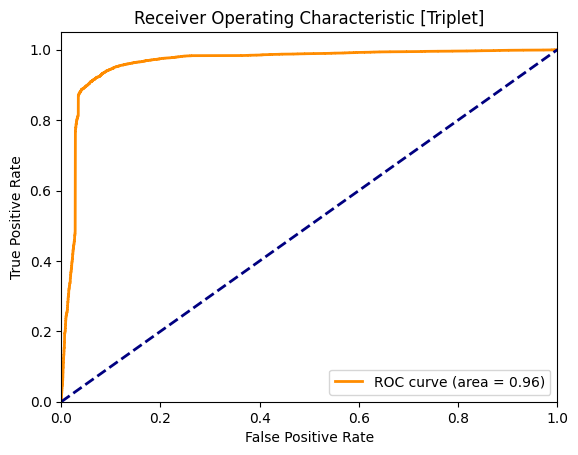

In [34]:
MODEL_ID = 'Triplet'
test_labels, scores_triplet = get_scores(x_test, triplet_model, triplet_pca, triplet_scaler, triplet_clf)
plot_roc_curve(MODEL_ID, test_labels, scores_triplet)

In [42]:
predicted_labels = np.where(scores_triplet > 0, 1, 0)
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6571
           1       0.94      0.95      0.95     12990

    accuracy                           0.93     19561
   macro avg       0.92      0.92      0.92     19561
weighted avg       0.93      0.93      0.93     19561



#### MultiSimilarity

100%|██████████| 612/612 [00:10<00:00, 58.84it/s] 


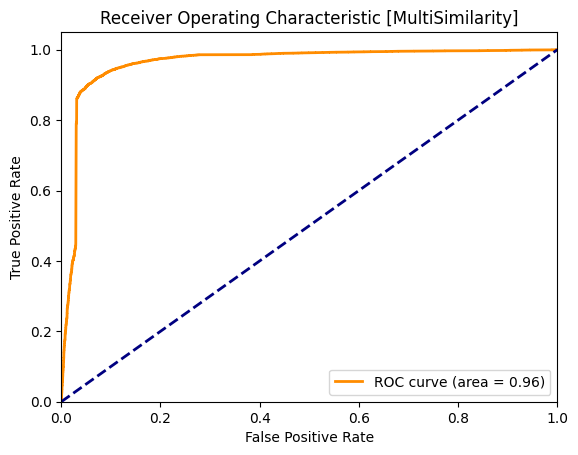

In [43]:
MODEL_ID = 'MultiSimilarity'
test_labels, scores_multisim = get_scores(x_test, multisim_model, multisim_pca, multisim_scaler, multisim_clf)
plot_roc_curve(MODEL_ID, test_labels, scores_multisim)

In [45]:
predicted_labels = np.where(scores_multisim > 0, 1, 0)
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6571
           1       0.94      0.95      0.95     12990

    accuracy                           0.93     19561
   macro avg       0.92      0.92      0.92     19561
weighted avg       0.93      0.93      0.93     19561



#### CosFace

100%|██████████| 612/612 [00:10<00:00, 58.69it/s] 


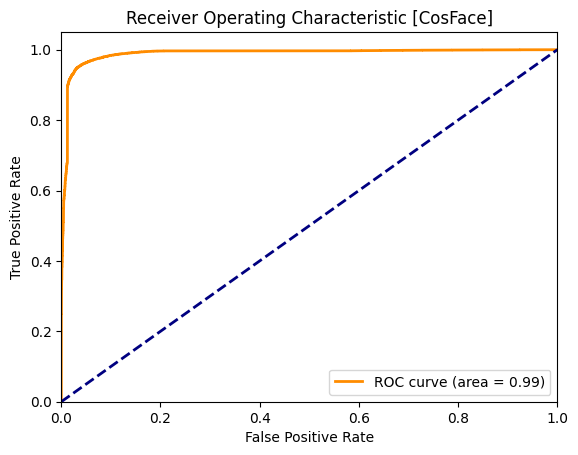

In [30]:
MODEL_ID = 'CosFace'
test_labels, scores_cosface = get_scores(x_test, cosface_model, cosface_pca, cosface_scaler, cosface_clf)
plot_roc_curve(MODEL_ID, test_labels, scores_cosface)

In [46]:
predicted_labels = np.where(scores_cosface > 0, 1, 0)
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6571
           1       0.96      0.97      0.97     12990

    accuracy                           0.96     19561
   macro avg       0.96      0.95      0.95     19561
weighted avg       0.96      0.96      0.96     19561



#### NPairs

100%|██████████| 612/612 [00:10<00:00, 59.83it/s] 


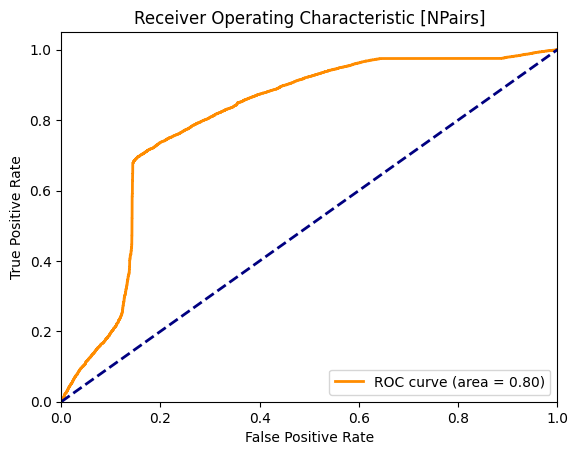

In [31]:
MODEL_ID = 'NPairs'
test_labels, scores_npairs = get_scores(x_test, npairs_model, npairs_pca, npairs_scaler, npairs_clf)
plot_roc_curve(MODEL_ID, test_labels, scores_npairs)

In [47]:
predicted_labels = np.where(scores_npairs > 0, 1, 0)
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.73      0.56      0.63      6571
           1       0.80      0.89      0.84     12990

    accuracy                           0.78     19561
   macro avg       0.76      0.73      0.74     19561
weighted avg       0.78      0.78      0.77     19561



# Error analysis through images

In [127]:
NUM_IMGS = 128

def plot_images(images, true_labels, predicted_labels):
    num_rows = NUM_IMGS // 4
    plt.figure(figsize=(10, 2*num_rows))

    for i in range(len(images)):
        plt.subplot(num_rows, 4, i + 1)
        img = images[i].squeeze(0)
        plt.imshow(img, cmap='gray')
        y_true = 'NO' if true_labels[i] else 'YES'
        y_pred = 'NO' if predicted_labels[i] else 'YES'
        plt.title(f'true: {y_true}, pred: {y_pred}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def get_labelled_img(model, scaler, pca, clf):
    data, labels = next(iter(x_test_loader))
    data_nsubset, labels_nsubset = data[:NUM_IMGS], labels[:NUM_IMGS]
    combined_dataset = [(data_nsubset[i], labels_nsubset[i]) for i in range(len(data_nsubset))]
    embeddings, _ = get_all_embeddings(combined_dataset, model)
    embeddings = pca.transform(scaler.transform(embeddings.cpu().numpy()))

    predictions = clf.predict(embeddings)

    return data.cpu(), labels_nsubset.cpu(), predictions

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


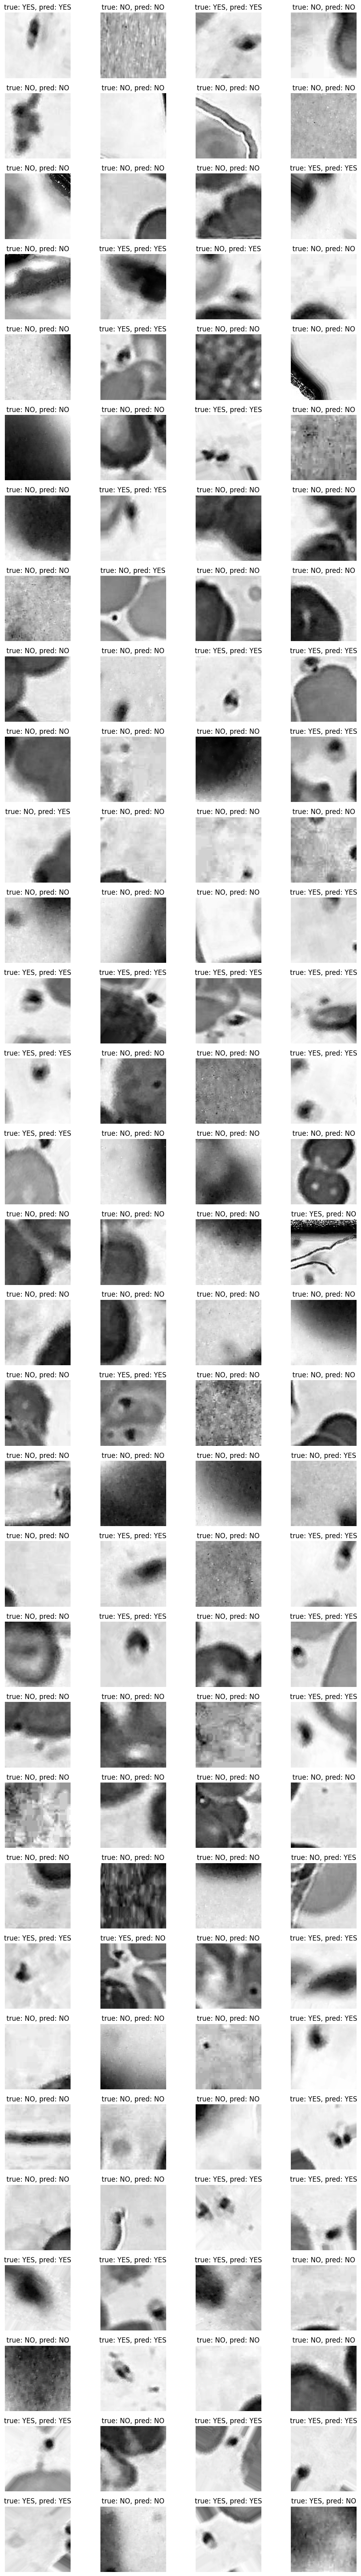

In [128]:
imgs, y_true, y_pred = get_labelled_img(triplet_model, triplet_scaler, triplet_pca, triplet_clf)
plot_images(imgs, y_true, y_pred)